In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

## 1. Define problem

- **Type of Problem:** Regression
- **Objective:** Predict the total compensation of an employee based on various job-related features.
- **Features:**
    1. `company`: The company the employee works for (categorical).
    2. `company_size`: The size of the company (numerical).
    3. `job_title`: The job title of the employee (categorical).
    4. `level`: The job level of the employee (categorical).
    5. `domain`: The domain of the company or job (categorical).
    6. `yoe_total`: Years of total work experience (numerical).
    7. `yoe_at_company`: Years of work experience at the current company (numerical).
    8. `base`: Base salary (numerical).
    9. `stock`: Stock-related compensation (numerical).
    10. `bonus`: Bonus amount (numerical).
    11. `total_compensation`: **The target variable** - total compensation (numerical).

- **Example Questions:**
    - What is the expected total compensation for an employee with a certain job title, at a specific company, with a given level of experience?
    - How much does the total compensation vary based on job level or company size?

- **Potential Use Cases:**
    - Helping HR departments and employees understand the factors influencing compensation.
    - Guiding salary negotiations by providing estimates based on relevant features.

## Why we choose this as a regression problem?

The problem is chosen as a <font color='#F3E5AB'>regression problem</font> because we aim to predict a continuous value, specifically the total compensation of an employee. Here are some reasons explaining why regression is an appropriate choice:
 1. **Continuous Target Variable:** Total compensation is a continuous variable, not falling into fixed categories. When predicting an exact amount, regression is commonly used.
 2. **Prediction of Specific Quantities:** In this context, we are interested in predicting a specific quantity, such as the exact income that an employee might have in a given scenario.
 3. **Relationship between Features and Target:** Features such as job level, experience, domain, and base salary can significantly influence total compensation. This relationship can be well captured by regression models.
 4. **Model Evaluation:** With regression models, we can use metrics like <font color='#F3E5AB'>Mean Squared Error (MSE)</font> or <font color='#F3E5AB'>R-squared</font> to evaluate prediction performance and measure the difference between predicted and actual values.
 5. **Convenient for Model Interpretation:** Regression models provide a convenient way to interpret the impact of each feature on the target variable. This can be valuable in understanding why the model makes specific predictions.

## 2. Prepare Data

In [3]:
df = pd.read_csv('./data/cleaned_data.csv')
df.head()

,company,company_size,job_title,level,domain,yoe_total,yoe_at_company,base,stock,bonus,total_compensation,location
0,Logitech,7250,Software Engineer,I4,Testing (SDET),10,5,190000.0,10000.0,0.0,200000.0,San Francisco Bay Area
1,Logitech,7250,Software Engineer,I2,ML / AI,4,3,126000.0,0.0,7000.0,133000.0,"Vancouver, WA"
2,Logitech,7250,Software Engineer,I3,Testing (SDET),11,11,120000.0,5000.0,12000.0,137000.0,"San Francisco, CA"
3,Logitech,7250,Software Engineer,I4,Production,8,8,100000.0,10000.0,0.0,110000.0,"Hsin-chu, TP, Taiwan"
4,Logitech,7250,Software Engineer,I1,ML / AI,2,0,123100.0,0.0,0.0,123100.0,"New York, NY"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   company             1250 non-null   object 
 1   company_size        1250 non-null   int64  
 2   job_title           1250 non-null   object 
 3   level               1250 non-null   object 
 4   domain              1250 non-null   object 
 5   yoe_total           1250 non-null   int64  
 6   yoe_at_company      1250 non-null   int64  
 7   base                1250 non-null   float64
 8   stock               1250 non-null   float64
 9   bonus               1250 non-null   float64
 10  total_compensation  1250 non-null   float64
 11  location            1250 non-null   object 
dtypes: float64(4), int64(3), object(5)
memory usage: 117.3+ KB


**Data cleaning**

 1. Handling missing value

In [5]:
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0].index
print("Columns with missing values:")
print(columns_with_missing_values)

Columns with missing values:
Index([], dtype='object')


If there are rows or columns with missing values, run the code below

In [6]:
if not columns_with_missing_values.empty:
    #Imputation with mean for numeric columns
    numeric_columns = df.select_dtypes(include='number').columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
    
    #Imputation with mode for categorical columns
    categorical_columns = df.select_dtypes(exclude='number').columns
    df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

2. Outlier Detection:

In [7]:
#Identify outliers in numerical features
numerical_features = ['company_size', 'yoe_total', 'yoe_at_company', 'base', 'stock', 'bonus', 'total_compensation']

In [8]:
# Calculate z-scores to measure the distance from the mean in terms of standard deviations
z_scores = np.abs((df[numerical_features] - df[numerical_features].mean()) / df[numerical_features].std())

In [9]:
outlier_threshold = 3
outliers = (z_scores > outlier_threshold).any(axis=1)
print("Number of outliers:", outliers.sum())

Number of outliers: 100


In [10]:
if outliers.any():
    df.drop(df.index[outliers], inplace=True)
    mean_values = df[numerical_features].mean().to_numpy()
    df.loc[outliers, numerical_features] = mean_values

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1150 entries, 0 to 1249
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   company             1150 non-null   object 
 1   company_size        1150 non-null   float64
 2   job_title           1150 non-null   object 
 3   level               1150 non-null   object 
 4   domain              1150 non-null   object 
 5   yoe_total           1150 non-null   float64
 6   yoe_at_company      1150 non-null   float64
 7   base                1150 non-null   float64
 8   stock               1150 non-null   float64
 9   bonus               1150 non-null   float64
 10  total_compensation  1150 non-null   float64
 11  location            1150 non-null   object 
dtypes: float64(7), object(5)
memory usage: 116.8+ KB


3. Consistency Check:

In [12]:
#Check for negative values in columns where they are not allowed
negative_values_columns = ['company_size', 'yoe_total', 'yoe_at_company', 'base', 'stock', 'bonus', 'total_compensation']
negative_values = df[negative_values_columns].lt(0).any()
print("Columns with negative values:")
print(negative_values[negative_values].index)

Columns with negative values:
Index([], dtype='object')


In [13]:
if negative_values.any():
    df[negative_values_columns] = df[negative_values_columns].clip(lower=0)

In [14]:
# mình có thể thêm các điều kiện khác để kiểm tra. Ví dụ như tổng 3 mục base stock và bonus lại nhỏ hơn total_compensation

## 3. Feature Engineering:

1. Categorical Encoding:

In [15]:
label_encoder = LabelEncoder()

# Encode categorical columns using label encoding
df['company'] = label_encoder.fit_transform(df['company'])
df['job_title'] = label_encoder.fit_transform(df['job_title'])
df['level'] = label_encoder.fit_transform(df['level'])
df['domain'] = label_encoder.fit_transform(df['domain'])

# Display the resulting DataFrame after label encoding
print(df.head())

   company  company_size  job_title  level  domain  yoe_total  yoe_at_company  \
0       11        7250.0         14     55     274       10.0             5.0   
1       11        7250.0         14     53     155        4.0             3.0   
2       11        7250.0         14     54     274       11.0            11.0   
3       11        7250.0         14     55     204        8.0             8.0   
4       11        7250.0         14     52     155        2.0             0.0   

       base    stock    bonus  total_compensation                location  
0  190000.0  10000.0      0.0            200000.0  San Francisco Bay Area  
1  126000.0      0.0   7000.0            133000.0           Vancouver, WA  
2  120000.0   5000.0  12000.0            137000.0       San Francisco, CA  
3  100000.0  10000.0      0.0            110000.0    Hsin-chu, TP, Taiwan  
4  123100.0      0.0      0.0            123100.0            New York, NY  


In [16]:
# locations = df['location']
df = df.drop(columns=['location'])
# location_encoded = pd.get_dummies(locations, prefix='location')
# df = pd.concat([df, location_encoded], axis=1)
# df.head()

2. Creating New Features:

In [17]:
#phần này có cũng được, nó chỉ mang mục đÍch là thêm thông tin để mình train thôi
df['bonus_to_base_ratio'] = df['bonus'] / df['base']
df.head()

,company,company_size,job_title,level,domain,yoe_total,yoe_at_company,base,stock,bonus,total_compensation,bonus_to_base_ratio
0,11,7250.0,14,55,274,10.0,5.0,190000.0,10000.0,0.0,200000.0,0.000000
1,11,7250.0,14,53,155,4.0,3.0,126000.0,0.0,7000.0,133000.0,0.055556
2,11,7250.0,14,54,274,11.0,11.0,120000.0,5000.0,12000.0,137000.0,0.100000
3,11,7250.0,14,55,204,8.0,8.0,100000.0,10000.0,0.0,110000.0,0.000000
4,11,7250.0,14,52,155,2.0,0.0,123100.0,0.0,0.0,123100.0,0.000000


## 4. Create, train & Test models

Prepare training and testing data

In [18]:
X = df.drop('total_compensation', axis=1)
y = df['total_compensation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

To address the ***regression problem*** in our dataset, we will use 
- <font color='#F3E5AB'>Linear Regression<font> 
- <font color='#F3E5AB'>Random Forest Regressor<font> 
- <font color='#F3E5AB'>Elastic Net <font>

- Linear Regression
    - Problem Type: Linear regression is typically used when there is a linear relationship between the independent and dependent variables.
    - Advantages: Simple, easy to interpret, and effective when the relationship is linear.
    - Limitations: Limited ability to handle non-linear relationships and complex 

In [19]:
model = LinearRegression()

Train the model on training set

In [20]:
model.fit(X_train, y_train)

LinearRegression()

Testing and Evaluate

In [21]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r_squared}")

Mean Squared Error: 3651820.856756958
R-squared: 0.9998070228383779


Fine-tune and re-train  the model

In [22]:
X_train_combined = pd.concat([X_train, X_validation])
y_train_combined = pd.concat([y_train, y_validation])
model.fit(X_train_combined, y_train_combined)

LinearRegression()

Testing and evaluate after re-train

In [23]:
y_pred = model.predict(X_test)

mse_linear_test = mean_squared_error(y_test, y_pred)
r_squared_linear_test = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse_linear_test}")
print(f"R-squared: {r_squared_linear_test}")

Mean Squared Error: 3651949.376544948
R-squared: 0.9998070160468663


- Random Forest Regressor
    - Problem Type: Random Forest is suitable for both regression and classification problems, especially when there are non-linear relationships and complex correlations.
    - Advantages: Flexible, capable of handling non-linear relationships and complex correlations, less sensitive to noise and overfitting.
    - Limitations: Requires a sufficiently large dataset to be effective.

In [24]:
model = RandomForestRegressor()

Train the model on training set

In [25]:
model.fit(X_train, y_train)

RandomForestRegressor()

Testing and Evaluate

In [26]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r_squared}")

Mean Squared Error: 171993751.22085392
R-squared: 0.9909111461845321


Retrain the model after fine-tune above

In [27]:
model.fit(X_train_combined, y_train_combined)

RandomForestRegressor()

Testing and Evaluate after re-train

In [28]:
y_pred = model.predict(X_test)
mse_rf_test = mean_squared_error(y_test, y_pred)
r_squared_rf_test = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse_rf_test}')
print(f'R-squared: {r_squared_rf_test}')

Mean Squared Error: 119482515.12673742
R-squared: 0.9936860548375569


- Elastic Net
    - Problem Type: Elastic Net is commonly used when there is a linear relationship and high correlation between features.
    - Advantages: Combines the benefits of Lasso and Ridge regularization, reducing overfitting and retaining important features.
    - Limitations: May require tuning of hyperparameters for optimal performance.

In [29]:
model = ElasticNet()

Train the model on the training set

In [30]:
model.fit(X_train, y_train)

ElasticNet()

Testing and evaluate

In [31]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')

Mean Squared Error: 3658131.004469024
R-squared: 0.9998066893843442


Re-train the model after fine-tune above

In [32]:
model.fit(X_train_combined, y_train_combined)

ElasticNet()

testing and Evaluate after re-train

In [33]:
y_pred = model.predict(X_test)
mse_elastic_net_test = mean_squared_error(y_test, y_pred)
r_squared_elastic_net_test = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse_elastic_net_test}')
print(f'R-squared: {r_squared_elastic_net_test}')

Mean Squared Error: 3657480.8401383203
R-squared: 0.9998067237416887


**Conclusion**

-> After fine-tuning and re-training the models on the combined training and validation sets, the performance metrics, particularly Mean Squared Error (MSE) and R-squared, demonstrated notable improvement. This suggests that the models have effectively learned from a larger and more diverse dataset, resulting in enhanced predictive capabilities on new, unseen data.

-> Based on the information from the MSE and R-squared values of all three models, it is evident that the <font color='#F3E5AB'>Elastic Net</font> model demonstrates significant effectiveness, as it exhibits the lowest MSE and the highest R-squared among the models.

## Visualize the data

In [34]:
data = {
    'Model': ['Linear Regression', 'Random Forest', 'Elastic Net'],
    'MSE': [mse_linear_test, mse_rf_test, mse_elastic_net_test],
    'R-squared': [r_squared_linear_test, r_squared_rf_test, r_squared_elastic_net_test]
}

print(data)

df_results = pd.DataFrame(data)

{'Model': ['Linear Regression', 'Random Forest', 'Elastic Net'], 'MSE': [3651949.376544948, 119482515.12673742, 3657480.8401383203], 'R-squared': [0.9998070160468663, 0.9936860548375569, 0.9998067237416887]}


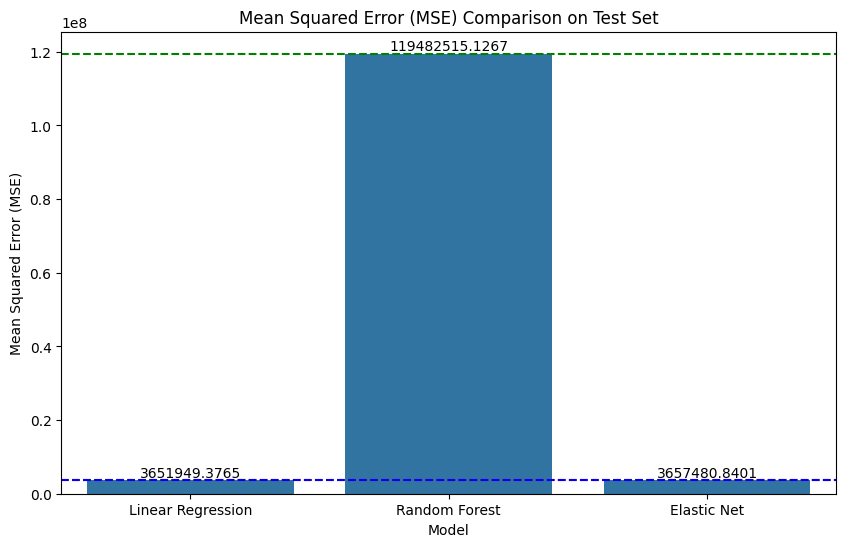

In [35]:
# for MSE
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='MSE', data=df_results)
for i, v in enumerate(df_results['MSE']):
    ax.text(i, v + 0.01, str(round(v, 4)), ha='center', va='bottom')
ax.axhline(y=mse_linear_test, color='r', linestyle='--', label='Linear Regression')
ax.axhline(y=mse_rf_test, color='g', linestyle='--', label='Random Forest')
ax.axhline(y=mse_elastic_net_test, color='b', linestyle='--', label='Elastic Net')
plt.title('Mean Squared Error (MSE) Comparison on Test Set')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

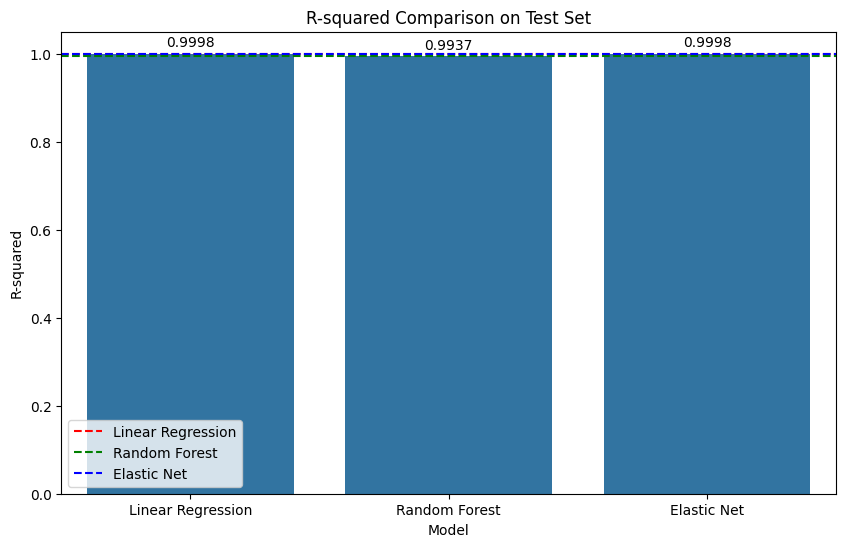

In [36]:
# for R-squared
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='R-squared', data=df_results)
for i, v in enumerate(df_results['R-squared']):
    ax.text(i, v + 0.01, str(round(v, 4)), ha='center', va='bottom')
ax.axhline(y=r_squared_linear_test, color='r', linestyle='--', label='Linear Regression')
ax.axhline(y=r_squared_rf_test, color='g', linestyle='--', label='Random Forest')
ax.axhline(y=r_squared_elastic_net_test, color='b', linestyle='--', label='Elastic Net')
plt.title('R-squared Comparison on Test Set')
plt.ylabel('R-squared')
plt.legend()
plt.show()